In [309]:
%load_ext autoreload
%autoreload 2
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *

def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1(train_ratio=.75)

In [262]:
import ssm
N = x_tr.shape[1]
D = 3

In [290]:
lds = ssm.LDS(N, D, emissions='gaussian_nn', hidden_layer_sizes=(20,))

In [298]:
q_lem_elbos, q_lem = lds.fit(x_tr, method="bbvi", variational_posterior="lds",
                             num_iters=10000, initialize=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

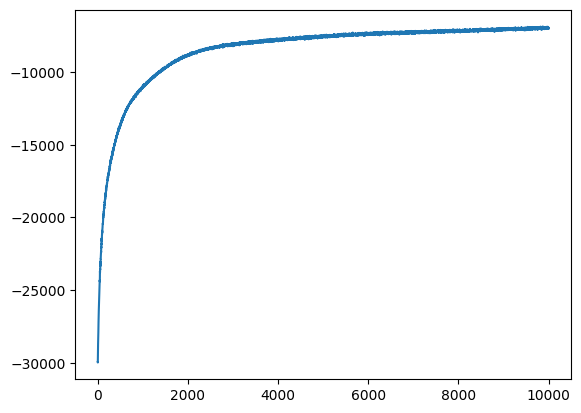

In [299]:
pyplot.plot(q_lem_elbos)

In [147]:
pyplot.plot(q_lem.mean_continuous_states[0])

AttributeError: 'SLDSMeanFieldVariationalPosterior' object has no attribute 'mean_continuous_states'

In [142]:
sample = q_lem.sample_continuous_states()[0]

AttributeError: 'SLDSMeanFieldVariationalPosterior' object has no attribute 'sample_continuous_states'

ValueError: shapes (1232,3) and (2,50) not aligned: 3 (dim 1) != 2 (dim 0)

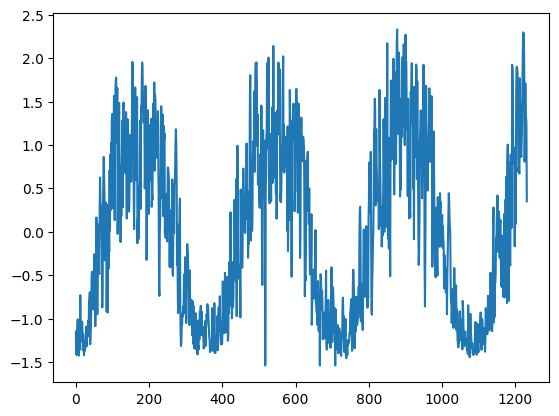

In [152]:
pyplot.rcdefaults()
pyplot.plot(x_tr[:,0])
pyplot.plot(lds.smooth(sample, x_tr)[:,1])

In [304]:
elbo, q_lem = lds.approximate_posterior(x_te, method="bbvi", variational_posterior="lds", num_iters=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [305]:
llk = []
num_samples = 1000
sample_x = numpy.empty((num_samples, x_te.shape[0], N))
for i in range(num_samples):
    sample_z = q_lem.sample()[0]
    sample_z2 = numpy.zeros(sample_z.shape[0])
    sample_x[i] = lds.emissions.sample(sample_z2, sample_z, numpy.zeros((x_te.shape[0],0)))
    mus = lds.emissions.forward(sample_z, numpy.zeros((x_te.shape[0],0)), None)[:,0]
    llk.append(np.sum(- .5 * (x_te - mus) ** 2 / etas - .5 * np.log(2 * np.pi * etas)))

In [306]:
mu = numpy.mean(sample_x, axis=0)
std = numpy.std(sample_x, axis=0)
lb, ub = mu - 1.96 * std, mu + 1.96 * std

In [307]:
numpy.mean(llk)

-1135.8728144794811

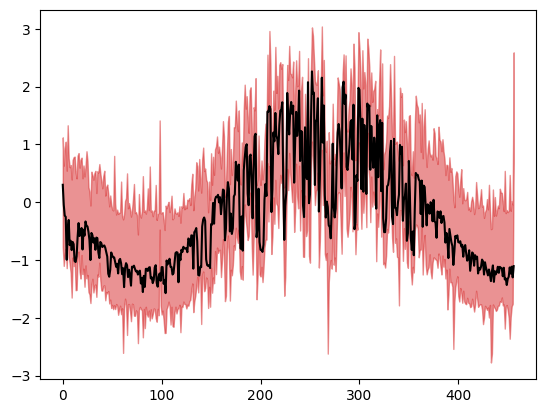

In [308]:
idx = 3
pyplot.rcdefaults()
pyplot.plot(x_te[:,idx], 'k')
#pyplot.plot(mu[:,0])
pyplot.fill_between(range(x_te.shape[0]), lb[:,idx], ub[:,idx], alpha=.5, color='C3')

In [67]:
etas = numpy.exp(lds.emissions.inv_etas)

In [74]:
np.sum(- .5 * (x_te - sample_x) ** 2 / etas - 0.5 * np.log(2 * np.pi * etas))

-4789.007803702906

In [239]:
sample_x.shape

(457, 4)